In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 LIBRARY YANG DI GUNAKAN


In [ ]:
import zipfile
import tensorflow as tf
import numpy as np
import splitfolders
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Data Collecting

In [ ]:
# Install the PyDrive wrapper & import libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1Qa83l7exEqfHljP-DRyyO8sqcXFRGPQt'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

## Unzip Dataset

In [ ]:
local_zip = 'chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [ ]:
# os.mkdir('ready_dataset')
base_dir = 'chest_xray'
os.listdir(base_dir)

['NORMAL', 'PNEUMONIA']

In [ ]:
normal_dir = os.path.join(base_dir, 'NORMAL')
pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')

In [ ]:
class_name = ['NORMAL', 'PNEUMONIA']

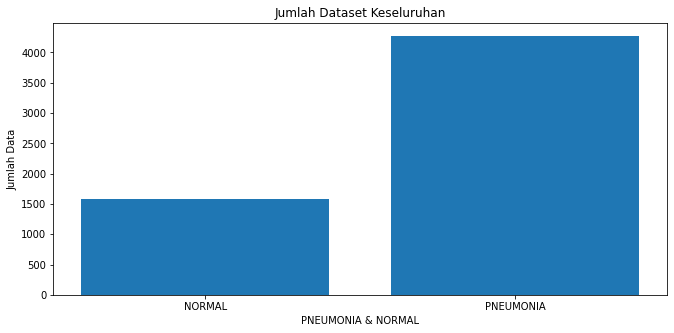

In [ ]:
list_jumlah_file_all = []

# loop untuk menyimpan jumlah masing-masing file tiap kelas kedalam list
for kelas in os.listdir(base_dir):
    list_file_kelas = os.listdir(os.path.join(base_dir, kelas)) 
    banyaknya_file = len(list_file_kelas)
    list_jumlah_file_all.append(banyaknya_file) # masukkan jumlahnya ke dalam list
    
x = class_name # variabel yang berisi classname
y = list_jumlah_file_all # list dari banyaknya jumlah file keseluruhan yang diambil dari perulangan diatas
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(5)
plt.bar(x, y)
plt.title('Jumlah Dataset Keseluruhan', loc='center')
plt.xlabel('PNEUMONIA & NORMAL')
plt.ylabel('Jumlah Data')
plt.show()

#### l = []
for i in base_dir:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

## Exploratory Data Analysis

# Data Preprocessing

## Split Data

In [ ]:
splitfolders.ratio(base_dir, output = 'ready_dataset', seed = 1337, ratio = (.7,0.1,0.2))

train_dir = os.path.join('ready_dataset', 'train')
validation_dir = os.path.join('ready_dataset', 'val')
test_dir = os.path.join('ready_dataset', 'test')
os.listdir(train_dir)
os.listdir(validation_dir)
os.listdir(test_dir)
# normal_dir = os.path.join(base_dir, 'NORMAL')
# pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')

Copying files: 5856 files [00:05, 1038.86 files/s]


['NORMAL', 'PNEUMONIA']

## Data Augmentation

In [ ]:
def to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
  train_dir,   
  target_size=(150,150),
  color_mode='grayscale',
  class_mode='binary',  
  shuffle=True,
  batch_size=64)

validation_generator = validation_datagen.flow_from_directory(
  validation_dir,  
  target_size=(150,150,1),
  color_mode='grayscale',
  class_mode='binary',
  shuffle=True,
  batch_size=64)

test_generator = test_datagen.flow_from_directory(
  test_dir,  
  target_size=(150,150),
  color_mode='grayscale',
  class_mode='binary',
  shuffle=True,
  batch_size=64)

Found 4099 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [ ]:
image, label = train_generator.next()

In [ ]:
len(image)

64

In [ ]:
label

array([1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)

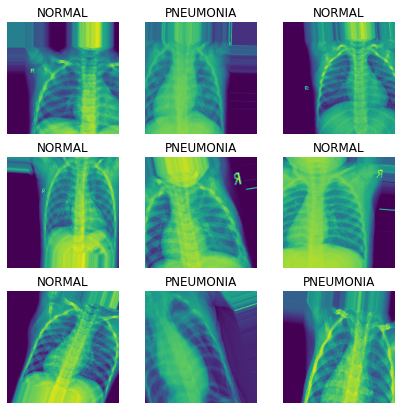

In [ ]:
plt.figure(figsize=(7,7))
for a, i in enumerate(range(10,19)):
    ax = plt.subplot(3,3,a+1)
    plt.imshow(image[i].reshape((150,150)))
    plt.title(class_name[int(label[i])])
    plt.axis("off")

## Modelling

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(150,150,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128 , activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1 , activation = 'sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 patience = 2,
                                                 verbose=1,
                                                 factor=0.3,
                                                 min_lr=0.000001)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
65/65 [==============================] - 45s 691ms/step - loss: 0.3980 - accuracy: 0.7724 - val_loss: 4.7801 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 2/100
65/65 [==============================] - 45s 687ms/step - loss: 0.2915 - accuracy: 0.8805 - val_loss: 3.9442 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.8883
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
65/65 [==============================] - 44s 673ms/step - loss: 0.2731 - accuracy: 0.8883 - val_loss: 3.3155 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 4/100
65/65 [==============================] - 44s 676ms/step - loss: 0.2319 - accuracy: 0.9078 - val_loss: 2.7392 - val_accuracy: 0.7299 - lr: 3.0000e-04
Epoch 5/100
65/65 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9061
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
65/65 [==============================]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

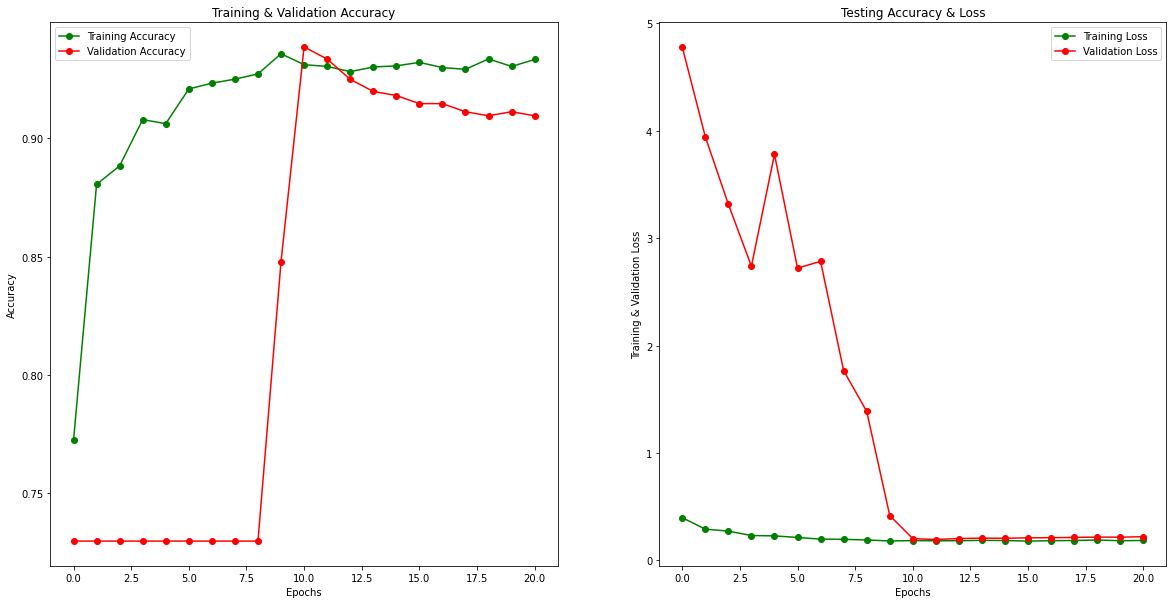

In [ ]:
epochs = range(21)
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

## Evaluasi Model

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss:", results[0])
print("test acc:", results[1])



Evaluate on test data
19/19 [==============================] - 10s 509ms/step - loss: 0.1701 - accuracy: 0.9445
test loss: 0.1700906604528427
test acc: 0.9445392489433289


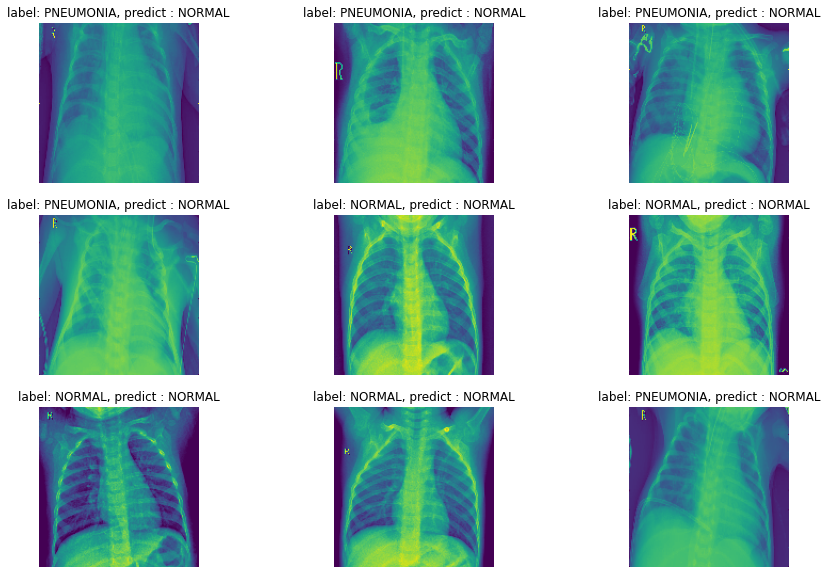

In [ ]:
image, label = next(iter(test_generator))

plt.figure(figsize=(15,10))
for i in range(9) :
    TrueLabel = class_name[int(label[i])]
    plt.subplot(3,3,i+1)
    plt.axis('off')
    y_pred = int(model.predict(image[i].reshape((1,150,150,1)),verbose=0))
    plt.imshow(tf.squeeze(image[i]))
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}')